In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.optimize import curve_fit

In [33]:
#define relevant constants

#Z boson mass
mZ = 91.188

#Z boson width
gammaZ = 2.4414

#QED running coupling
alpha = 1/(132.507)

#Fermi constant
GF = 1.16639*10**(-5)

#weinberg angle
thetaW = 0.222246

kappa = (np.sqrt(2)*GF*mZ**2)/(4*np.pi*alpha)

In [34]:
#relevant constants to electrons and muons

#electron charge 
Q_e = -1

#electron vector coupling
V_e = -1/2+2*thetaW

#electron axial vector coupling
A_e = -1/2

#muon vector coupling
V_mu = -1/2+2*thetaW

#muon axial vector coupling
A_mu = -1/2

In [35]:
#function for calculating chi_1
def chi_1(s):
    return (kappa*s*(s-mZ**2))/((s-mZ**2)**2+gammaZ**2*mZ**2)

In [36]:
#function for calculating chi_2
def chi_2(s):
    return (kappa**2*s**2)/((s-mZ**2)**2+gammaZ**2*mZ**2)

In [37]:
#function for calculating A_0
def A_0(s):
    term_1 = Q_e**2-2*Q_e*V_mu*V_e*chi_1(s)
    term_2 = (A_mu**2+V_mu**2)*(A_e**2+V_e**2)*chi_2(s)
    return term_1 + term_2

In [38]:
#function for calculating A_1
def A_1(s):
    term_1 = -4*Q_e*A_mu*A_e*chi_1(s)
    term_2 = 8*A_mu*V_mu*A_e*V_e*chi_2(s)
    return term_1 + term_2

In [39]:
#calculate the differential cross section for an event
def cross_section(s,cos_theta):
    return (alpha**2/(4*s))*(A_0(s)*(1+cos_theta**2)+A_1(s)*cos_theta)

In [89]:
for s in np.linspace(E_min**2, E_max**2, 10):
    print(f"s = {s:.2f}, A_0 = {A_0(s):.5f}, A_1 = {A_1(s):.5f}")


s = 100.00, A_0 = 0.99991, A_1 = -0.01759
s = 4533.33, A_0 = 1.18120, A_1 = -1.70923
s = 8966.67, A_0 = 23.84077, A_1 = 20.01325
s = 13400.00, A_0 = 1.95216, A_1 = 3.89358
s = 17833.33, A_0 = 1.48677, A_1 = 2.75360
s = 22266.67, A_0 = 1.35542, A_1 = 2.34058
s = 26700.00, A_0 = 1.29549, A_1 = 2.12735
s = 31133.33, A_0 = 1.26156, A_1 = 1.99718
s = 35566.67, A_0 = 1.23984, A_1 = 1.90946
s = 40000.00, A_0 = 1.22477, A_1 = 1.84634


In [80]:
#constants for mcmc
E_min = 10
E_max = 200
N_steps = 10_000_000
burn_in = 100_000
thinning = 10

In [81]:
# acceptance-rejection MCMC method to generate drell-yan events
def mcmc():
    events = []
    max_cs = 0

    # #find max cross section for rejection 
    for i in np.linspace(E_min**2, E_max**2, 100):
        for j in np.linspace(-1, 1, 100):
            max_cs = max(max_cs, cross_section(i, j))
    
    for t in tqdm.tqdm(range(N_steps)):
        
        #sample randomly
        E_cm = np.random.uniform(E_min, E_max)
        cos_theta = np.random.uniform(-1,1)

        #calculate s
        s = E_cm**2

        #calculate diff cross section
        cs = cross_section(s, cos_theta)

        #random number 
        u = np.random.uniform(0,1)
        
        #acceptance-rejection
        if u < cs / (max_cs):
            #accept this event after burn in
            if t >= burn_in:
                events.append((E_cm, cos_theta, cs))

    #thinning
    events = events[::thinning]
    
    return np.array(events)

100%|██████████| 10000000/10000000 [01:46<00:00, 93785.74it/s]


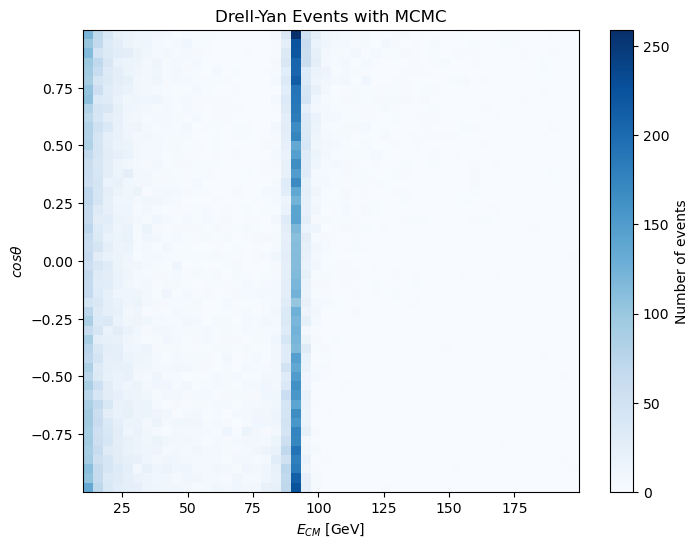

In [82]:
events = mcmc()
        
plt.figure(figsize=(8,6))
plt.hist2d(events[:, 0], events[:, 1], bins=50, cmap='Blues')
plt.colorbar(label="Number of events")
plt.xlabel("$E_{CM}$ [GeV]")
plt.ylabel("$cos\\theta$")
plt.title("Drell-Yan Events with MCMC")
plt.show()

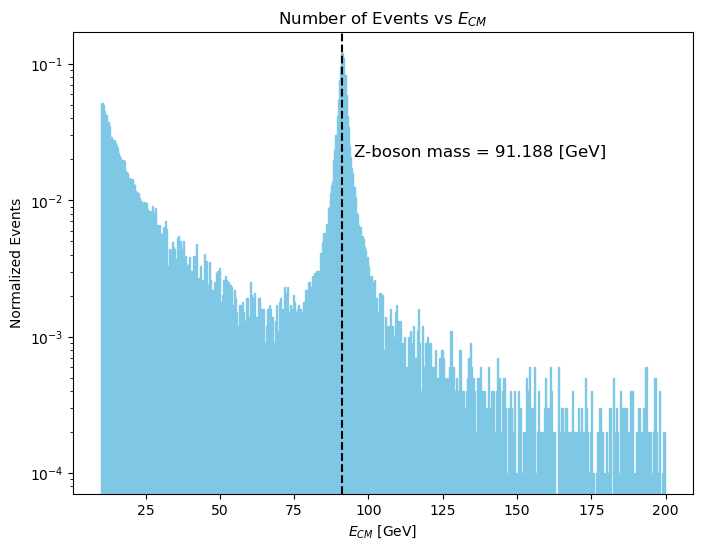

In [84]:
energy_values = events[:, 0]

# Plot 
plt.figure(figsize=(8, 6))
plt.hist(energy_values, bins=500, color='#7EC8E6', edgecolor='#7EC8E6', density=True)
plt.xlabel("$E_{CM}$ [GeV]")
plt.ylabel("Normalized Events")
plt.title("Number of Events vs $E_{CM}$")
plt.axvline(x=91.188, color='black', linestyle='--')
plt.text(95, 0.02, "Z-boson mass = 91.188 [GeV]", color='black', fontsize=12, verticalalignment='bottom')
plt.yscale('log')

plt.show()


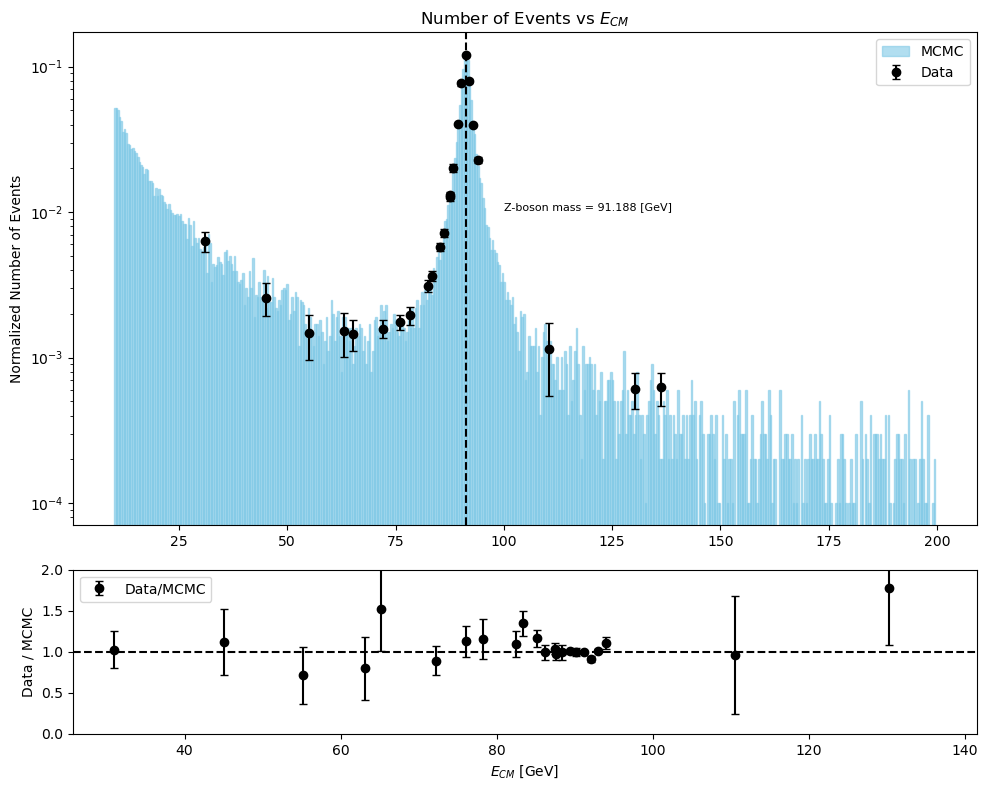

In [85]:
energy_values = events[:, 0]

# Data from ALEPH
data_energy = np.array([63.12, 72.18, 78.29, 82.5, 85.2, 87.49, 88.37, 89.42, 90.21, 91.23, 92.05, 92.99, 94.03, 110.46, 130.2, 136.21,
                        30.94, 45.11, 55.12, 65.15, 76.08, 83.37, 86.13, 87.53]) 
data_cs = np.array([0.0253, 0.0263, 0.0325, 0.052, 0.0956, 0.219, 0.336, 0.6759, 1.276, 2.0018, 1.322, 0.657, 0.381, 0.019, 0.0102, 0.0104,
                    0.105, 0.043, 0.0245, 0.0243, 0.0291, 0.061, 0.1191, 0.21]) 
data_cs_error_plus = np.array([0.0085, 0.0037, 0.0048, 0.0053, 0.0061, 0.01, 0.022, 0.0075, 0.044, 0.006, 0.04, 0.0068, 0.018, 0.01, 0.0028, 0.0026,
                               0.016, 0.011, 0.0084, 0.0057, 0.0034, 0.0048, 0.0076, 0.011])
data_cs_error_minus = np.array([0.0085, 0.0037, 0.0048, 0.0053, 0.0061, 0.01, 0.022, 0.0075, 0.044, 0.006, 0.04, 0.0068, 0.018, 0.01, 0.0028, 0.0026,
                                0.016, 0.011, 0.0084, 0.0057, 0.0034, 0.0048, 0.0076, 0.011]) 

#counts and bins
counts, bins = np.histogram(energy_values, bins=500, density=True)
fig = plt.figure(figsize=(10, 8))

# gridspec 
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])

#plot the mcmc
ax1.hist(energy_values, bins=500, color='#7EC8E6', edgecolor='#7EC8E6', density=True, alpha=0.6, label="MCMC")

# scale the data to MCMC (weights)
max_hist = max(counts)
max_cross_section = max(data_cs)
scaled_cross_section = (data_cs / max_cross_section) * max_hist
scaled_error_plus = (data_cs_error_plus / max_cross_section) * max_hist
scaled_error_minus = (data_cs_error_minus / max_cross_section) * max_hist

# plot the data
ax1.errorbar(data_energy, scaled_cross_section, yerr=[scaled_error_minus, scaled_error_plus], fmt='o', color='black', label="Data", capsize=3)
ax1.axvline(x=91.188, color='black', linestyle='--')
ax1.text(100, 0.01, "Z-boson mass = 91.188 [GeV]", color='black', fontsize=8, verticalalignment='bottom')
#ax1.set_xlabel("$E_{CM}$ [GeV]")
ax1.set_ylabel("Normalized Number of Events")
ax1.set_title("Number of Events vs $E_{CM}$")
ax1.set_yscale('log')
ax1.legend()

# data over MCMC plot
ax2 = fig.add_subplot(gs[1])

# ratio
ratio = scaled_cross_section / np.interp(data_energy, (bins[:-1] + bins[1:]) / 2, counts)

# Calculate error bars for the ratio
ratio_error = ratio * np.sqrt((scaled_error_plus / scaled_cross_section)**2 + (scaled_error_minus / scaled_cross_section)**2)

# plot the ratio
ax2.errorbar(data_energy, ratio, yerr=ratio_error, fmt='o', color='black', capsize=3, label="Data/MCMC")
ax2.axhline(y=1, color='black', linestyle='--') 
ax2.set_xlabel("$E_{CM}$ [GeV]")
ax2.set_ylabel("Data / MCMC")
ax2.set_ylim(0, 2) 
ax2.legend()

plt.tight_layout()
plt.show()



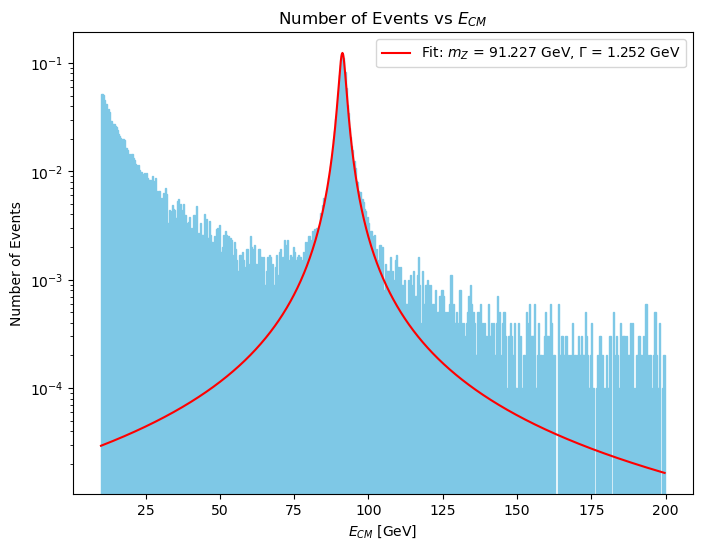

In [86]:
energy_values = events[:, 0]

#good fit for resonances
def breit_wigner(x, amplitude, mean, gamma):
    return amplitude * (gamma**2) / ((x - mean)**2 + gamma**2)

#plot
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(energy_values, bins=500, color='#7EC8E6', edgecolor='#7EC8E6', density=True)

# fit to histo
bin_centers = (bins[:-1] + bins[1:]) / 2
initial_guess = [max(n), 91.188, 2] 

#curve fit
popt, pcov = curve_fit(breit_wigner, bin_centers, n, p0=initial_guess)

#fit parameters
amplitude, mean, gamma = popt

#plot fit
x_fit = np.linspace(bins[0], bins[-1], 1000)
y_fit = breit_wigner(x_fit, *popt)
plt.plot(x_fit, y_fit, color='red', label=f'Fit: $m_Z$ = {mean:.3f} GeV, $\Gamma$ = {gamma:.3f} GeV')
plt.xlabel("$E_{CM}$ [GeV]")
plt.ylabel("Number of Events")
plt.title("Number of Events vs $E_{CM}$")
plt.yscale('log')
plt.legend()

plt.show()


In [87]:
#now, recognize that Gamma is particle's decay width. We can recover it's lifetime by t = h_bar/Gamma
#convert gamma from GeV to eV:energy_values
Gamma = popt[-1]*1e9
t = 6.582e-16/Gamma
print("lifetime of z-boson: ",t, " s")

lifetime of z-boson:  5.255828739120338e-25  s


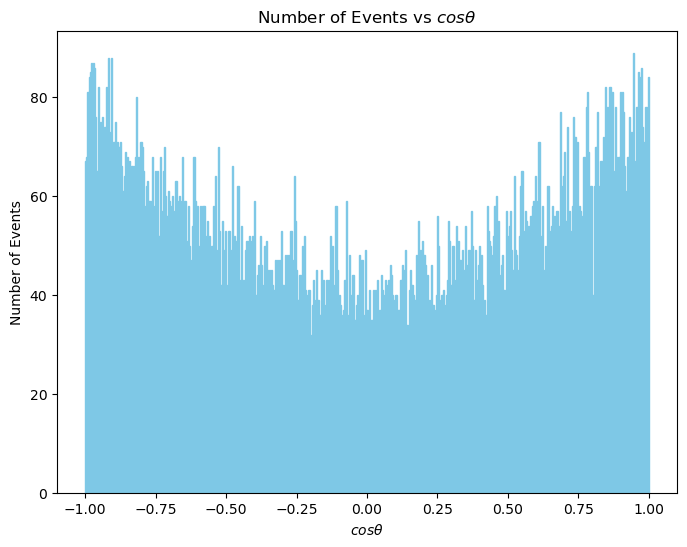

In [88]:
cos_theta_values = events[:, 1]

#plot
plt.figure(figsize=(8, 6))
plt.hist(cos_theta_values, bins=500, color='#7EC8E6', edgecolor='#7EC8E6')
plt.xlabel("$cos\\theta$")
plt.ylabel("Number of Events")
plt.title("Number of Events vs $cos\\theta$")

plt.show()